## Tutorial

Let's start with importing our package.

In [1]:
import pheno

Set up an environment for nice plotting within this notebook.

In [2]:
%matplotlib inline

### Dataset

#### Load

We're going to look at cherry blossoms at Washington, D.C. The meteorological (weather) dataset is called `usa_ds3505` and downloaded from [NOAA NCDC](http://gis.ncdc.noaa.gov).  The observation dataset is called `cherry_dc` and managed by [NPS](http://www.nps.gov/cherry/). You can access actual files in HDF5 format (.h5) at `/input/df/met` and `/input/df/obs` directories.

`translator` argument specifies a mapping of station codes between observation and meteorological datasets. In this example, `cherry_dc` is an observation dataset collected from `DC`, which is mapped to the Reagan National Airport, whose station code is `724050` in `usa_ds3505` dataset.

In [3]:
ds = pheno.data.DataSet('usa_ds3505', 'cherry_dc', translator={'DC': 724050})

The dataset may consists of multiple locations, cultivars, or phenological stages.

In [4]:
print(ds)

met_station=724050, obs_station=DC, cultivar=None, stage=None


The dataset has two cultivars.

In [5]:
ds.cultivars()

['Kwanzan', 'Yoshino']

The observations were made at five different phenological stages.

In [6]:
ds.stages()

['Extension of Florets',
 'Florets Visible',
 'Green Color In Buds',
 'Peak Bloom',
 'Peduncle Elongation',
 'Puffy White']

To create a model for a single location/cultivar/stage, explicitly set `cultivar` and `stage` arguments.

In [7]:
ds.set(cultivar='Yoshino', stage='Peak Bloom')

#### Data Exploration

Selected weather data can be obtained by `weather()` method and viewed in `DataFrame`.

In [8]:
ds.weather().tail()

,tavg
timestamp,
2015-06-30 19:00:00,31.180000
2015-06-30 20:00:00,31.620000
2015-06-30 21:00:00,31.100000
2015-06-30 22:00:00,31.033333
2015-06-30 23:00:00,30.440000


Or directly plotted in this notebook.

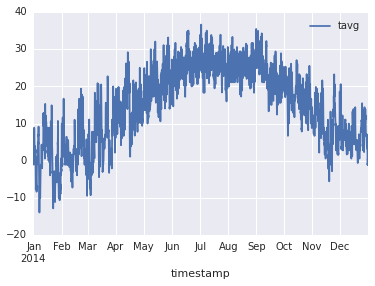

In [9]:
ds.weather().loc['2014'].plot()

Selected observation can be retrieved in a similar manner using `observation()`.

In [10]:
ds.observation().tail()

year
2010   2010-03-31
2011   2011-03-29
2012   2012-03-20
2013   2013-04-09
2014   2014-04-10
Name: Peak Bloom, dtype: datetime64[ns]

### Estimator

#### Calibration

`Estimator` is a model class that implements own algorithm for phenology prediction. `pheno.estimation` package provides more than four individual models.

Our growing degree hour model can be instantiated with the dataset we just created.

In [11]:
gd = pheno.estimation.GrowingDegree(ds)

For any prediction, we must specify model parameters. An easy way to find them is to just call `calibrate()` method. Let's do it with 11 years of data from 2000 to 2010.

Note that a tuple `(2000, 2010)` will be conveniently translated into a list of consecutive years like `[2000, 2001, ..., 2009, 2010]`. Be careful with double parentheses though.

Calibration could take up to a few minutes or an hour depending on your computing power.

In [12]:
gd.calibrate((2000, 2010))

differential_evolution step 1: f(x)= 3.40299
differential_evolution step 2: f(x)= 3.40299
differential_evolution step 3: f(x)= 3.40299
differential_evolution step 4: f(x)= 3.40299
differential_evolution step 5: f(x)= 3.40299
differential_evolution step 6: f(x)= 3.40299
differential_evolution step 7: f(x)= 2.88809
differential_evolution step 8: f(x)= 2.88809
differential_evolution step 9: f(x)= 2.88809
differential_evolution step 10: f(x)= 2.88809
differential_evolution step 11: f(x)= 2.88809
differential_evolution step 12: f(x)= 1.98189
differential_evolution step 13: f(x)= 1.98189
differential_evolution step 14: f(x)= 1.98189
differential_evolution step 15: f(x)= 1.98189
differential_evolution step 16: f(x)= 1.98189
differential_evolution step 17: f(x)= 1.98189
differential_evolution step 18: f(x)= 1.98189
differential_evolution step 19: f(x)= 1.98189
differential_evolution step 20: f(x)= 1.97658
differential_evolution step 21: f(x)= 1.96866
differential_evolution step 22: f(x)= 1.966

{'Ds': 32.91447929543088, 'Rd': 127.36946222589518, 'Tb': 6.8328184059665684}

#### Estimation

The calibrated parameter is in a Python dictionary. For example, here we have a starting date (`Ds`) of 32 that indicates the beginnig of February. Base temperature (`Tb`) of 6.83 does not sound too bad. Accumulation requirement (`Rd`) is 127.37.

First check the actual full bloom date for 2010.

In [13]:
gd.observe(2010)

datetime.datetime(2010, 3, 31, 12, 0)

Then predict a full bloom date with our model.

In [14]:
gd.estimate(2010)

datetime.datetime(2010, 3, 31, 15, 0)

As 2010 was a part of our calibration dataset, it's not surprising to see that they are very close.

Let's do a test with another year that was not included in the calibration dataset.

In [15]:
gd.estimate(2015)

datetime.datetime(2015, 4, 7, 5, 0)

The full bloom date of 2015 is estimated to April 7, which is not very far from the actual date, [April 10](http://havecamerawilltravel.com/cherry-blossoms/2015-peak-bloom-forecasts/).

### Plot

We can easily make a plot with the model output.

In [16]:
import matplotlib.pyplot as plt

`x` axis of the plot will be years from 2000 to 2010.

In [17]:
x = gd._years((2000, 2010))
x

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]

`y` axis of the plot will have observations and estimations.

In [18]:
y_obs = gd.observes(x, julian=True)
y_est = gd.estimates(x, julian=True)

`matplotlib` provides a function for line graph. Solid line indicates observation and dashed line indicates estimation.

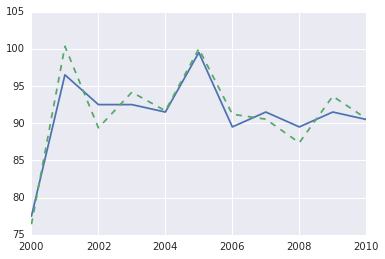

In [19]:
plt.plot(
    x, y_obs, '-',
    x, y_est, '--'
)

A scatter plot can be also easily made out of the same data.

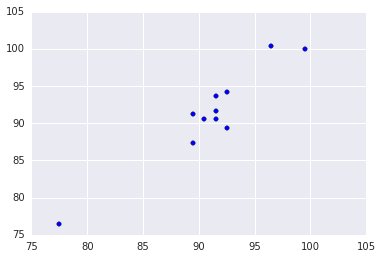

In [20]:
plt.scatter(y_obs, y_est)

### Ensemble

`Ensemble` model is composed of multiple other models. First create four individual models as described above. The same dataset will be used.

In [21]:
models = [
    pheno.estimation.GrowingDegree(ds),
    pheno.estimation.ChillingForce(ds),
    pheno.estimation.BetaFunc(ds),
    pheno.estimation.StandardTemperature(ds),
]

Calibrate models.

In [22]:
years = (2005, 2010)
[m.calibrate(years) for m in models]

differential_evolution step 1: f(x)= 1.50913
differential_evolution step 2: f(x)= 1.50913
differential_evolution step 3: f(x)= 1.50913
differential_evolution step 4: f(x)= 1.50913
differential_evolution step 5: f(x)= 1.44928
differential_evolution step 6: f(x)= 1.44928
differential_evolution step 7: f(x)= 1.44928
differential_evolution step 8: f(x)= 1.33799
differential_evolution step 9: f(x)= 1.33799
differential_evolution step 10: f(x)= 1.33799
differential_evolution step 11: f(x)= 1.33799
differential_evolution step 12: f(x)= 1.33799
differential_evolution step 13: f(x)= 1.33799
differential_evolution step 14: f(x)= 1.33799
differential_evolution step 15: f(x)= 1.22037
differential_evolution step 16: f(x)= 1.22037
differential_evolution step 17: f(x)= 1.22037
differential_evolution step 18: f(x)= 1.22037
differential_evolution step 19: f(x)= 1.22037
differential_evolution step 20: f(x)= 1.22037
differential_evolution step 21: f(x)= 1.20642
differential_evolution step 22: f(x)= 1.206

[{'Ds': 38.59697820860022, 'Rd': 187.96236114531837, 'Tb': 4.395446931578781},
 {'Ds': -50.77286337618488,
  'Rc': -147.82469562761776,
  'Rh': 95.712069205922106,
  'Tc': 8.889474570937459},
 {'Ds': 37.299912333090468,
  'Rg': 5.6249362856718932,
  'To': 35.008147949994793,
  'Tx': 49.835176563123575},
 {'Ds': 22.699459516860099,
  'Ea': 103.53785790323901,
  'Rd': 157.44139740230762,
  'Ts': 3.4811247738160178}]

Then create an ensemble out of them. `use()` method takes care of setting up weight coefficients.

In [23]:
en = pheno.estimation.Ensemble(ds).use(models, years, how='RMSE')

Weight coefficients can be now viewed.

In [24]:
en.coeff

OrderedDict([('w0', 0.2531142933959537), ('w1', 0.21094368029501018), ('w2', 0.25970387737600165), ('w3', 0.27623814893303444)])

You should be already familiar with the basic use of the model as it is based on the same `Estimator` class.

In [25]:
en.estimate(2010)

datetime.datetime(2010, 3, 31, 6, 27, 6, 470627)

### Remarks

So far, the essence of `pheno` package has been introduced. It should be sufficient for running individual/ensemble models for a simple configuration with a single location/cultivar/stage of the dataset. But when it comes to multiple datasets compiled with multiple configurations, manual management of models will be extremely painful. That's why `ModelSuite`, `ModelGroup`, and `ModelCollection` from `pheno.model` package would come in handy.

- `ModelSuite`: a suite of models run on a single configuration
- `ModelGroup`: a group of suites run on a dataset, likely consists of multiple configurations
- `ModelCollection`: a collection of groups run on multiple datasets, mostly for aggregating cross-validation results

They are equipped with diverse methods for producing tables and figures. Look at all that extravagant list of files in the SPACE drive.

Descriptions on these classess may deserve another tutorial. In the mean time, please refer to `main.py` in the repository for a sneak peek.